In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from scipy import stats
import numpy as np

def get_ohlcv_yf(code,start="2021-01-01",end="2024-12-31", interval="1d"): #interval = [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
    ohlcv = yf.download(code,start=start,end=end, interval=interval)
    ohlcv.columns = ohlcv.columns.droplevel(1)
    ohlcv.columns.name = None
    ohlcv.index.name = None
    ohlcv["Return"] = (ohlcv["Close"] - ohlcv["Open"]) / ohlcv["Open"]
    return ohlcv

def plot_ohclv(ohlcv):
    fig = plt.figure(figsize=(15,6))

    for i, feature in enumerate(["Close","High","Low","Open","Volume","Return"]):
        ax = plt.subplot(3,2,i+1)
        ax.set_title(feature)
        ohlcv[feature].tail(500).plot(ax=ax)
    plt.tight_layout()

def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

class TakerBackTest:

    def __init__(self, collateral, leverage):
        self.collateral = collateral
        self.leverage = leverage
        self.maker_fee = 0.000  # 株コム api経由の信用取引は手数料無料
        self.taker_fee = 0.000 # 株コム api経由の信用取引は手数料無料
        self.slippage = 0.000

    def round_size(self, size):
        # サイズの最小で丸める. こ
        return round(size, 4)
    
    def run(self, data_with_signal):
        # DataFrameは重いので, np.Arrayまたはlistで計算を行う.
        df = data_with_signal.copy()
        
        # 使用データ.
        open_prices = df['Open'].values
        high_prices = df['High'].values
        low_prices = df['Low'].values
        close_prices = df['Close'].values
        signals = df['signal'].values  # signal列に-1～1が入っている想定.

        # バックテストにより計算するデータ.
        positions = []
        pnls = []
        fees = []
        max_losses = []
        balances = []

        # 前回のループの内容を保持するデータ.
        pre_signal = 0
        pre_position = 0
        pre_balance = self.collateral
        
        for i in range(len(df)):
            if signals[i] == pre_signal:
                position = pre_position
            else:
                position = pre_balance / open_prices[i] * self.leverage * signals[i]
            pnl = position * (close_prices[i] - open_prices[i])
            fee = abs(position - pre_position) * open_prices[i] * (self.taker_fee + self.slippage)
            max_loss = position * (low_prices[i] - open_prices[i]) if position >= 0 else position * (high_prices[i] - open_prices[i])
            balance = pre_balance + pnl - fee
            positions.append(position)
            pnls.append(pnl)
            fees.append(fee)
            max_losses.append(max_loss)
            balances.append(balance)
            pre_signal = signals[i]
            pre_position = positions[i]
            pre_balance = balances[i]
        df['position'] = positions
        df['pnl'] = pnls
        df['fee'] = fees
        df['max_loss'] = max_losses
        df['balance'] = balances
        df['max_dd'] = df['balance'].cummax() - df['balance']
        return df
    
def plot_return(strategy):
    fig = plt.figure(figsize=(10,3))
    plt.title("各戦略の累積リターン")
    plt.plot(strategy['pnl'].cumsum(),label="戦略1",color='magenta')
    plt.plot(strategy["Return_objective"].cumsum(), label='HODL', color='lightgray')
    plt.plot(strategy['dd'], label='DD', color='k')
    plt.legend()
    sr_daily = strategy["pnl"].mean()/strategy["pnl"].std()
    sr_anual = sr_daily * np.sqrt(365)
    print(f'SR(daily): {sr_daily:.5f}')
    print(f'SR(yearly): {sr_anual:.5f}')
    print(f'最大DD: {strategy["dd"].max():.5f}')

def plot_backtest(strategy):
    back_test = TakerBackTest(collateral=10000, leverage=1)
    result = back_test.run(strategy)
    plt.figure(figsize=(10, 4))
    plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.plot(result['balance'], label='証拠金残高', color='magenta', zorder=2)
    plt.plot(result['balance'].shift(1) + result['max_loss'], label='瞬間最大損失', zorder=1)
    plt.plot(result['max_dd'], label='最大DD', color='k')
    plt.plot(10000 / result['Open'].iloc[0] * result['Close'], label='HODL', color='lightgray', zorder=0)
    print(f'最大DD: {strategy["dd"].max():.5f}')
    plt.legend()
    plt.subplot2grid((3, 1), (2, 0))
    plt.plot(result['signal'], label='signal')
    plt.legend()

In [3]:
### 検証銘柄と検証特徴量###
objective = "5713.T"
feature = "HG=F"
#########################

####### 検証条件 ########
start = "2015-01-01"
end = "2024-12-31"
interval = "1d"
########################

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,Return
2015-01-05,2719.760986,2756.298497,2708.343014,2750.970110,1811000,-0.011345
2015-01-06,2627.656006,2681.701074,2627.656006,2679.417480,2245500,-0.019318
2015-01-07,2645.163574,2665.715924,2597.208091,2601.775280,2025000,0.016676
2015-01-08,2673.327881,2735.746129,2668.760692,2674.089079,2025500,-0.000285
2015-01-09,2695.402344,2706.820315,2670.282808,2686.267967,1456500,0.003400
...,...,...,...,...,...,...
2024-12-24,3488.000000,3518.000000,3469.000000,3472.000000,618400,0.004608
2024-12-25,3504.000000,3508.000000,3452.000000,3495.000000,812000,0.002575
2024-12-26,3531.000000,3531.000000,3493.000000,3503.000000,1220800,0.007993
2024-12-27,3605.000000,3613.000000,3549.000000,3553.000000,1404900,0.014636


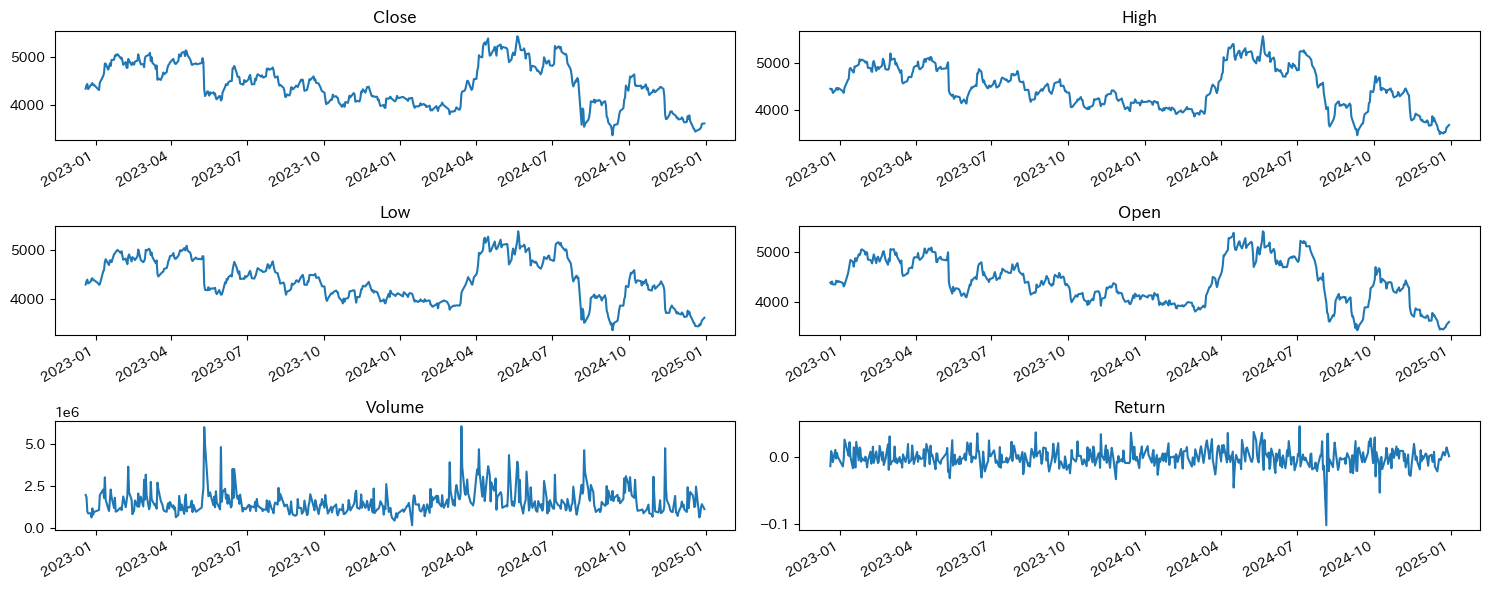

In [4]:

objective_ohlcv = get_ohlcv_yf(objective, start = start,end = end, interval= interval)
plot_ohclv(objective_ohlcv)
objective_ohlcv.isnull().sum()
objective_ohlcv

[*********************100%***********************]  1 of 1 completed


Close     0
High      0
Low       0
Open      0
Volume    0
Return    0
dtype: int64

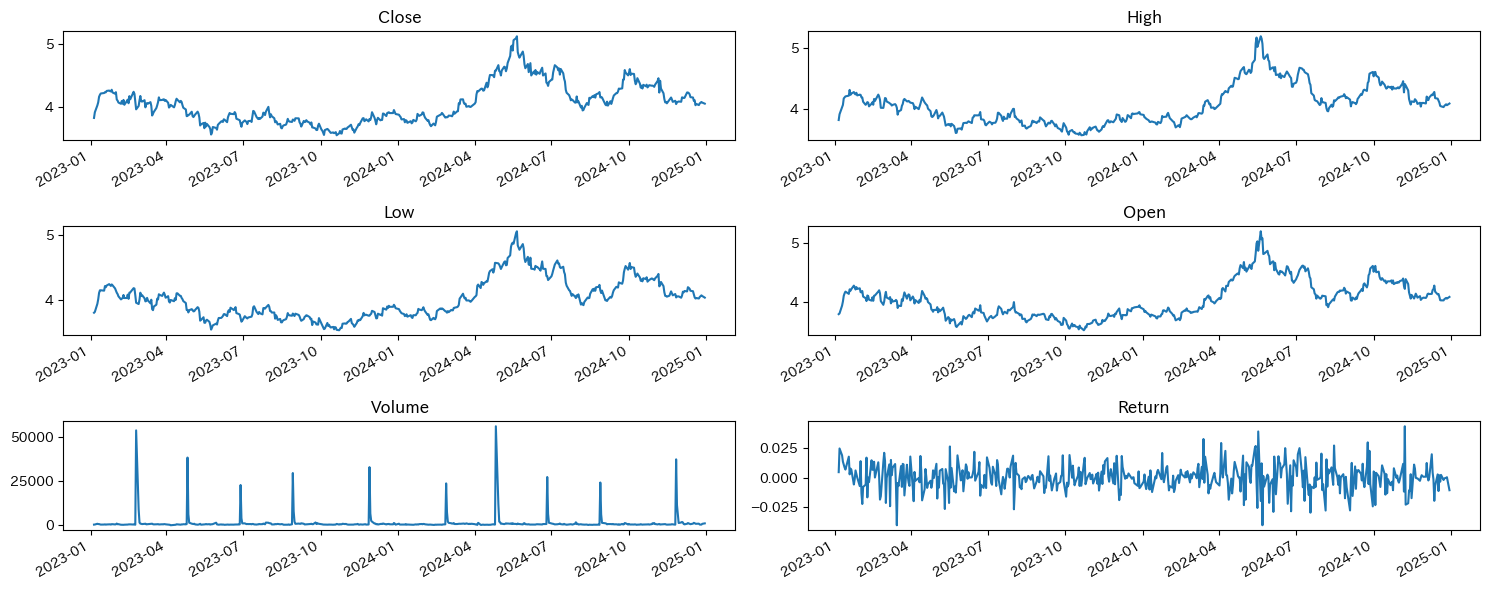

In [5]:
feature_ohlcv = get_ohlcv_yf(feature, start = start,end = end, interval= interval)
plot_ohclv(feature_ohlcv)
feature_ohlcv.isnull().sum()


In [6]:
merged_df = objective_ohlcv[["Close","High","Low","Open",'Return']].merge(feature_ohlcv[['Return']], left_index=True, right_index=True, suffixes=('_objective', '_feature'))
merged_df["Return_feature_s1"] = merged_df["Return_feature"].shift(1)
merged_df

,Close,High,Low,Open,Return_objective,Return_feature,Return_feature_s1
2015-01-05,2719.760986,2756.298497,2708.343014,2750.970110,-0.011345,-0.012900,NaN
2015-01-06,2627.656006,2681.701074,2627.656006,2679.417480,-0.019318,0.003220,-0.012900
2015-01-07,2645.163574,2665.715924,2597.208091,2601.775280,0.016676,0.001433,0.003220
2015-01-08,2673.327881,2735.746129,2668.760692,2674.089079,-0.000285,0.003934,0.001433
2015-01-09,2695.402344,2706.820315,2670.282808,2686.267967,0.003400,-0.004815,0.003934
...,...,...,...,...,...,...,...
2024-12-23,3482.000000,3487.000000,3428.000000,3455.000000,0.007815,-0.002108,0.002232
2024-12-24,3488.000000,3518.000000,3469.000000,3472.000000,0.004608,-0.000740,-0.002108
2024-12-26,3531.000000,3531.000000,3493.000000,3503.000000,0.007993,-0.000246,-0.000740
2024-12-27,3605.000000,3613.000000,3549.000000,3553.000000,0.014636,0.000246,-0.000246


Text(0, 0.5, 'Feature 1')

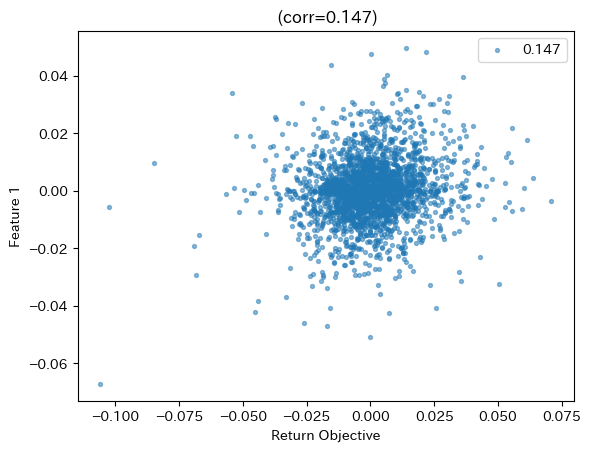

In [7]:
plot_corr(merged_df["Return_objective"],merged_df["Return_feature_s1"])
plt.xlabel("Return Objective")
plt.ylabel("Feature 1")

In [8]:
strategy1 = merged_df.copy()
strategy2 = merged_df.copy()

In [9]:
strategy1["Return_feature_s1_sign"] = np.sign(strategy1["Return_feature_s1"])
strategy1["signal"] = 0
strategy1.loc[strategy1["Return_feature_s1_sign"] == 1,"signal"] = 1
strategy1.loc[strategy1["Return_feature_s1_sign"] == -1,"signal"] = -1
print(strategy1["signal"].value_counts())
strategy1['pnl'] = strategy1["signal"]*strategy1["Return_objective"]
strategy1['dd'] = strategy1["pnl"].cumsum().cummax() - strategy1["pnl"].cumsum()

signal
 1    1184
-1    1117
 0      79
Name: count, dtype: int64


In [10]:
strategy2["signal"] = 0
strategy2.loc[strategy2["Return_feature_s1"] < 0.00,"signal"] = -0.5
strategy2.loc[strategy2["Return_feature_s1"] < -0.01,"signal"] = -1
strategy2.loc[strategy2["Return_feature_s1"] > 0.00,"signal"] = 0.5
strategy2.loc[strategy2["Return_feature_s1"] > 0.01,"signal"] = 1
print(strategy2["signal"].value_counts())
strategy2['pnl'] = strategy2["signal"]*strategy2["Return_objective"]
strategy2['dd'] = strategy2["pnl"].cumsum().cummax() - strategy2["pnl"].cumsum()

signal
 0.5    807
-0.5    791
 1.0    377
-1.0    326
 0.0     79
Name: count, dtype: int64


/tmp/ipykernel_15887/1412191675.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategy2.loc[strategy2["Return_feature_s1"] < 0.00,"signal"] = -0.5


最大DD: 0.30054


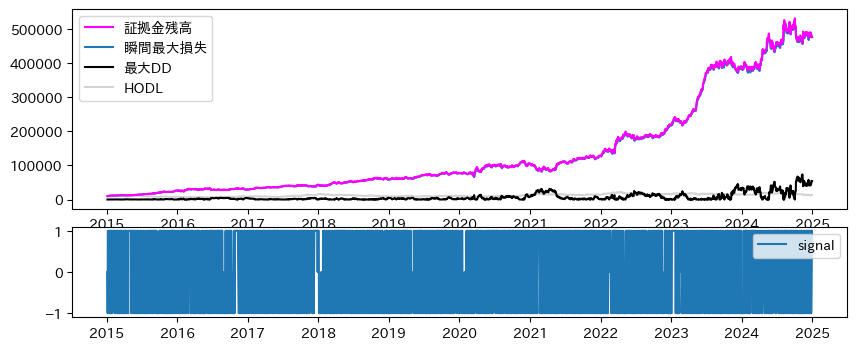

In [11]:
plot_backtest(strategy1)

最大DD: 0.18694


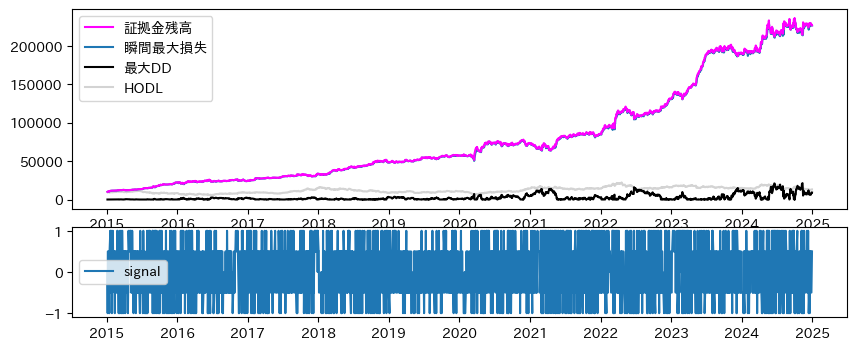

In [12]:
plot_backtest(strategy2)